<a href="https://colab.research.google.com/github/alimoorreza/CS167-Project-2/blob/main/Project2_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__Project \# 2__
Name:

Date:

## Problem Description:



### Hints/Tips Tricks
- If you want to accelerate the training process using graphical processing unit (GPU), do so from Colab's 'Notebook Settings' by enabling GPU:
  - Runtime-->Change runtime type-->GPU or TPU


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#__Fine-tuning a Pretrained Convolutional Neural Network (CNN) for fine-grained categoriztaion of an image__


* AlexNet was the winner of ImageNet challenge in 2012. Proposed by Alex Krizevsky, Ilya Sutskever, and Geofrey Hinton from University of Toronto.

* VGG was the winner of ImageNet (1000-class image classification) challenge in 2014. Proposed by Andrew Zisserman's group in Oxford University.

* ResNet was the winner of ImageNet challenge in 2015. Proposed by Kaiming He et al. from Microsoft Research.


[AlexNet: A. Krizhevsky, I. Sutskever, and G. Hinton, ImageNet Classification with Deep Convolutional Neural Networks, NIPS 2012](www.cs.toronto.edu/~fritz/absps/imagenet.pdf)

[VGG: Very Deep Convolutional Networks for Large-Scale Image Recognition - Karen Simonyan and Andrew Zisserman](https://arxiv.org/abs/1409.1556)

[ResNet: Deep Residual Learning for Image Recognition - Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1409.1556)



#__Bird Species: dataset visualization__
Download the dataset from the following link:

- [Bird Species Dataset](https://analytics.drake.edu/~reza/teaching/cs167_fall23/dataset/bird_species_v1.zip)
  - Each image size: __WxHx3__
    - Note that these are color images
  
<!--div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_fall23/notes/images/cifar-10-sprite.png" width=500/>
</div-->


In [2]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import pdb
root_dir                    = "/content/drive/MyDrive/cs167_fall23/datasets/bird_species_v1/train/"
name_of_the_bird_species    = os.listdir(root_dir)
if '.DS_Store' in name_of_the_bird_species:
  name_of_the_bird_species.remove('.DS_Store')

name_of_the_bird_species.sort()
sample_images = {}

print("Selected bird species for image recognition are as follows: ")
print("-------------------------------------------------------------------------")
for i in range(len(name_of_the_bird_species)):
  # select a random training image
  all_image_names_cur_species = os.listdir(root_dir + "/" + name_of_the_bird_species[i])
  random_index = torch.randint(len(all_image_names_cur_species), size=(1,)).item()
  img = cv2.imread(root_dir + "/" + name_of_the_bird_species[i] + "/" + all_image_names_cur_species[random_index])
  sample_images[name_of_the_bird_species[i]] = {'img':img, 'train_size':len(all_image_names_cur_species)}

  # display the name of the species
  print(f"{i+1:2}. {name_of_the_bird_species[i]:>25}: {len(all_image_names_cur_species):>20} training samples")

print("-------------------------------------------------------------------------")

Selected bird species for image recognition are as follows: 
-------------------------------------------------------------------------
 1.           ABBOTTS BABBLER:                   50 training samples
 2.         AMETHYST WOODSTAR:                   50 training samples
 3.        ASIAN CRESTED IBIS:                   50 training samples
 4.                 AZURE JAY:                   50 training samples
 5.              BARN SWALLOW:                   50 training samples
 6.         BELTED KINGFISHER:                   50 training samples
 7.                 CASSOWARY:                   50 training samples
 8.        CHINESE POND HERON:                   50 training samples
 9.           CHUCAO TAPACULO:                   50 training samples
10.  CREAM COLORED WOODPECKER:                   50 training samples
11.          CRESTED FIREBACK:                   50 training samples
12.           CRIMSON SUNBIRD:                   50 training samples
13.         DALMATIAN PELICAN:       

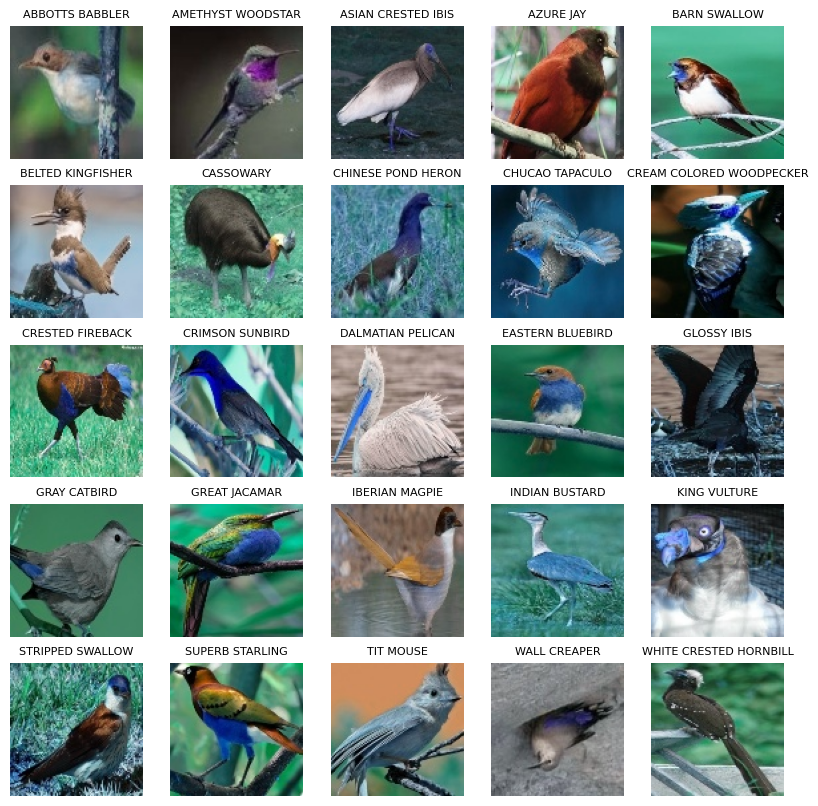

In [4]:
# showing some sample training images
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
  #pdb.set_trace()
  cur_sample = sample_images[name_of_the_bird_species[i-1]]
  img   = cur_sample['img']
  label = name_of_the_bird_species[i-1]
  figure.add_subplot(rows, cols, i)
  plt.title(label, fontsize=8)
  plt.axis("off")
  #print('image tensor size:', img.shape)
  plt.imshow(img)
plt.show()


#__Network Codes for AlexNet, VGGNet, and ResNet__
You can use the following network classes when you fine-tune your models.

In [ ]:
# CNN networks preparation for fine-tuning:
#     1) AlexNet
#     2) VGGNet
#     3) ResNet
#-----------------------------------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
import os
import pdb

class AlexNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AlexNet, self).__init__()
        net = models.alexnet(pretrained=True)

        self.features   = net.features
        self.avgpool    = net.avgpool

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        #print("shape of input: ", x.shape)
        x = self.features(x)
        #print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        #print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #print("output shape (self.classifier): ", x.shape)
        return x

# You can give any name to your new network, e.g., VGG.
# You should load the pretrained VGG model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'

class VGGNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, bn=False):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)

        self.features = net.features
        self.avgpool = net.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )
        #pdb.set_trace()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# You can give any name to your new network, e.g., ResNet.
# You should load the pretrained ResNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'

class ResNet152(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet152, self).__init__()
        net = models.resnet152(pretrained=True)

        num_features = net.fc.in_features
        net.fc = nn.Linear(num_features, num_classes)

        self.conv1 = net.conv1
        self.bn1 = net.bn1
        self.relu = net.relu
        self.maxpool = net.maxpool

        self.layer1 = net.layer1
        self.layer2 = net.layer2
        self.layer3 = net.layer3
        self.layer4 = net.layer4

        self.avgpool = net.avgpool
        self.fc = net.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



#__Model 1: AlexNet for fine-tuning and evaluating__

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")



In [ ]:
# visualize the accuracy curves for AlexNet


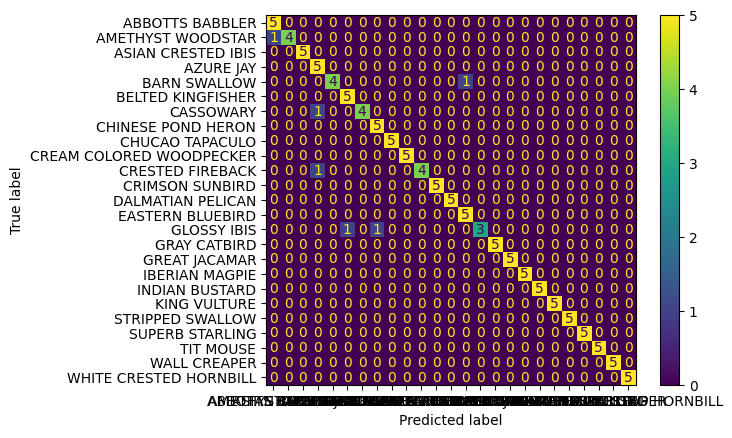

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix

#__Model 2: VGGNet for fine-tuning and evaluating__

#__Model 3: ResNet for fine-tuning and evaluating__